<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/uas_DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Latar Belakang**

#**1. Data Collection**

###**1.1 Import Drive**

In [28]:
# 1.1 Mount Google Drive (jika menggunakan Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**1.2 Import Library & Dataset**

In [29]:
# 1.2 Import library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/DM/salaries.csv"  # Ganti sesuai lokasi file kamu
df = pd.read_csv(file_path)

##**1.3 Cek Awal Data**

In [30]:
# 1.3 Cek ukuran dan tampilkan 5 baris pertama
print("Jumlah baris & kolom:", df.shape)

Jumlah baris & kolom: (141566, 11)


In [31]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


##**1.4 Deskripsi Kolom**

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141566 entries, 0 to 141565
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           141566 non-null  int64 
 1   experience_level    141566 non-null  object
 2   employment_type     141566 non-null  object
 3   job_title           141566 non-null  object
 4   salary              141566 non-null  int64 
 5   salary_currency     141566 non-null  object
 6   salary_in_usd       141566 non-null  int64 
 7   employee_residence  141566 non-null  object
 8   remote_ratio        141566 non-null  int64 
 9   company_location    141566 non-null  object
 10  company_size        141566 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.9+ MB


#**2. Pre Processing**

##**2.1 Cek Missing Value**

In [33]:
# Cek missing values
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


##**2.2 Cek Tipe Data Tiap Kolom**

In [34]:
df.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


##**2.3 Transformasi**

In [35]:
# Ubah nama kolom agar seragam
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Cek ulang kolom
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [36]:
# Pastikan kolom salary_in_usd bertipe numerik
df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')

# Hapus baris yang tidak memiliki nilai salary
df = df.dropna(subset=['salary_in_usd']).reset_index(drop=True)

#**3. Feature Engineering**

In [37]:
!pip install pycountry

In [38]:
import pycountry

# Fungsi untuk mengubah kode negara jadi nama lengkap
def convert_country(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code  # Kalau gagal, kembalikan kode aslinya

# Tambahkan kolom baru 'country_name'
df['country_name'] = df['company_location'].apply(convert_country)

In [39]:
# Buat label target berdasarkan distribusi gaji
df['salary_level'] = pd.qcut(df['salary_in_usd'], q=3, labels=['low', 'medium', 'high'])

# Tampilkan distribusinya
print(df['salary_level'].value_counts())

salary_level
low       48635
high      46958
medium    45973
Name: count, dtype: int64


#**4. Feature Engineering**

In [40]:
dt_model = DecisionTreeClassifier(
    max_depth=10,        # Batasi kedalaman
    min_samples_split=10,  # Minimum data untuk split
    class_weight='balanced',
    random_state=42
)

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Salin dataset dan encode fitur kategorikal
df_model = df.copy()

# Fitur yang digunakan
categorical_cols = ['job_title', 'company_location', 'employment_type', 'experience_level', 'company_size', 'remote_ratio']

# Label encoding
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_dict[col] = le

# Encode target
le_target = LabelEncoder()
df_model['salary_level_enc'] = le_target.fit_transform(df_model['salary_level'])

# Drop kolom yang tidak digunakan
X = df_model[categorical_cols]
y = df_model['salary_level_enc']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (113252, 6)
Test shape: (28314, 6)


#**5. Encode & Split**

#**6. Model Training**

In [42]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
search = RandomizedSearchCV(rf_base, param_grid, cv=3, n_iter=10, n_jobs=-1, scoring='accuracy')
search.fit(X_train, y_train)

best_rf = search.best_estimator_

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Inisialisasi & training
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Prediksi
y_pred = rf.predict(X_test)

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))

Accuracy: 0.5347531256622166
Classification Report:
               precision    recall  f1-score   support

        high       0.53      0.67      0.59      9392
         low       0.65      0.61      0.63      9727
      medium       0.40      0.31      0.35      9195

    accuracy                           0.53     28314
   macro avg       0.53      0.53      0.52     28314
weighted avg       0.53      0.53      0.53     28314



In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Inisialisasi dan training model
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

# Prediksi
y_pred = dt_model.predict(X_test)

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))

Accuracy: 0.5332697605424879
Classification Report:
               precision    recall  f1-score   support

        high       0.53      0.67      0.59      9392
         low       0.66      0.59      0.62      9727
      medium       0.40      0.33      0.36      9195

    accuracy                           0.53     28314
   macro avg       0.53      0.53      0.53     28314
weighted avg       0.53      0.53      0.53     28314



In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
print("CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

CV Accuracy: 0.5279 ± 0.0058


In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
print("Cross-Val Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

Cross-Val Accuracy: 0.5349 ± 0.0068


#**7. Visualisasi**

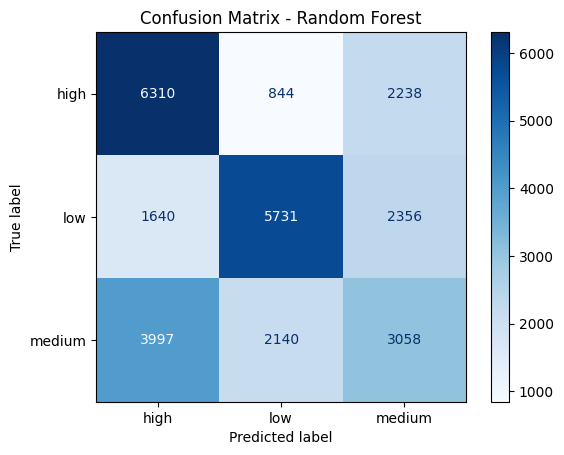

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le_target.classes_, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

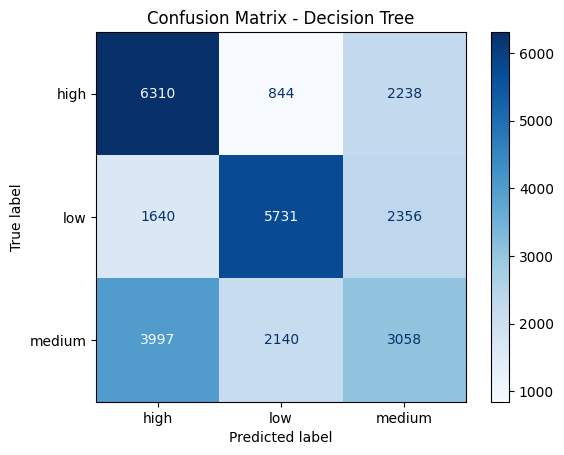

In [48]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=le_target.classes_, cmap="Blues"
)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

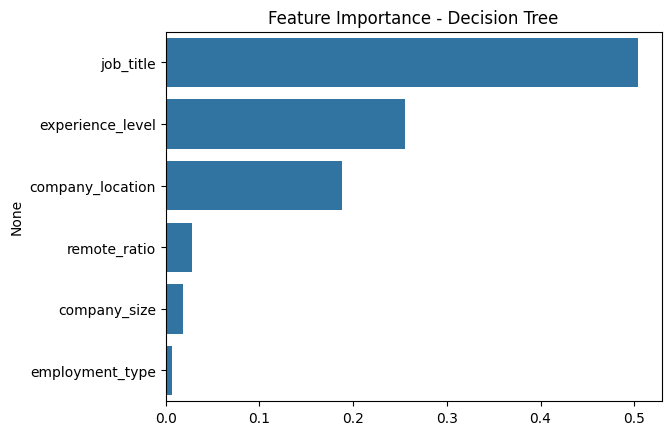

In [49]:
importances = dt_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance - Decision Tree")
plt.show()

/tmp/ipython-input-50-3551575876.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


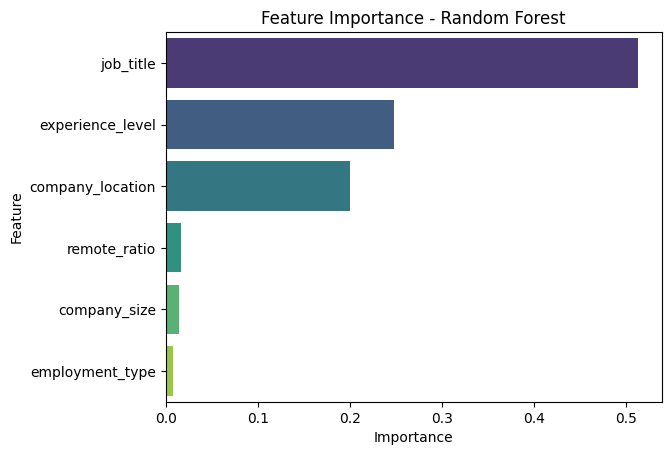

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()